# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.axes as Axes
from scipy.optimize import minimize
#from scipy.optimize import NonlinearConstraint

%matplotlib inline
import time
import pylab as pl
from IPython import display

%load_ext autotime

time: 311 µs (started: 2021-01-19 02:11:35 -05:00)


# Parameters

In [2]:
config = {"l": 1, # length of the pendulum
         "mp": 0.2, # mass of the pendulum
         "Mc": 1, # Mass of the cart
         "g": 9.81, # gravity
         "dt":0.09, # time step for MPC
         "Np": 24, #Horizn length
         "cart" : (0.6,0.2), # dimensions of the cart
         "iters" : 80, # Maximum number of iteration for the solution
         "q11": 12., # state coefficient diag_1
         "q22": 0.09, # diag_2
         "q33": 2., # diag_3
         "q44": 0.1, # diag_3
         "R" : 0.3 # Input Coefficient
         } 

Np=config["Np"]
bound_u=(-4.,4.)
bound =((bound_u,)*Np)
# x, xdot, theta, thetadot
curr_q = np.array([np.random.randn(1)[0]*2, 0., -np.random.randn(1)[0], 0.])
curr_q = np.reshape(curr_q,[4,1])
u = np.array(np.ones(Np))



time: 3.25 ms (started: 2021-01-19 02:11:45 -05:00)


# Helper functions

In [3]:
def state(curr_q,u,config):
    mp = config["mp"]
    l = config["l"]
    Mc = config["Mc"]
    g = config["g"]
    dt = config["dt"]
    
    #state x
    dq1 = curr_q[1]  # initial state of the cartpole
    # state xdot
    dq2 = (u+mp*np.sin(curr_q[2])*(l*(curr_q[3]**2)
                                          +g*np.cos(curr_q[2])))/(Mc+mp*(np.sin(curr_q[2])**2))
    # state theta
    dq3 = curr_q[3]
    # state thetadot
    dq4 = (-u*np.cos(curr_q[2])-mp*l*(curr_q[3]**2)
               *np.cos(curr_q[2])*np.sin(curr_q[2])
               -(Mc+mp)*g*np.sin(curr_q[2]))/(l*(Mc+mp*
                                                (np.sin(curr_q[2])**2)))
    next_q = curr_q+np.array([dq1,dq2,dq3,dq4])*dt
    return next_q

time: 928 µs (started: 2021-01-19 02:11:50 -05:00)


In [4]:
def cost_fn(u,curr_q,config):
    mp = config["mp"]
    l = config["l"]
    Mc = config["Mc"]
    g = config["g"]
    dt = config["dt"]
    Np= config["Np"]
    R = config["R"]
    cost=0
    q_ref = np.array([0., 0., np.pi, 0.])
    Q = np.array([[config["q11"], 0., 0.,  0.],
        [0., config["q22"], 0., 0.],
        [0., 0., config["q33"], 0.],
        [0., 0., 0., config["q44"]]])
    diff = np.zeros_like(q_ref)
    for i in range(Np):
        #if curr_q[2]>np.pi:
        #    curr_q[2] = -curr_q[2]

        next_q = state(curr_q,u[i], config)
        diff[0] = curr_q[0] - q_ref[0]
        diff[1] = curr_q[1] - q_ref[1]
        diff[2] = curr_q[2] - q_ref[2]
        diff[3] = curr_q[3] - q_ref[3]

        iter_cost = np.matmul(np.matmul(diff.T,Q),diff) + R*((u[i]-0.)**2)
        cost += iter_cost
        curr_q = next_q
    return cost

time: 1.1 ms (started: 2021-01-19 02:11:51 -05:00)


In [5]:


max_iter = config["iters"]
history_q = []
history_u = []
p=0.2
ls =0
for i in range(max_iter):
    history_q.append(curr_q)
    cost=cost_fn(u,curr_q,config)
    ls+=cost
    out=minimize(cost_fn,u,(curr_q,config), method='L-BFGS-B', bounds=bound,
                 options={'disp': False})

    u=out.x
    history_u.append(u[0])
    curr_q= state(curr_q,u[0], config)


time: 1min 42s (started: 2020-12-30 06:25:28 -05:00)


In [6]:
print('Average Loss:', ls/max_iter)



Average Loss: 218.97618199640428
time: 500 µs (started: 2020-12-30 06:27:10 -05:00)


# Helper Functions for display

In [8]:
def rotate_pos(pos, angle):

    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    #print(np.shape(np.dot(pos, rot_mat.T)))
    return np.dot(pos, rot_mat.T)

def square(center_x, center_y, shape, angle):

    #square_xy = np.array([shape[0], shape[1]])
    square_xy = np.array([[shape[0], shape[1]],
                              [-shape[0], shape[1]],
                              [-shape[0], -shape[1]],
                              [shape[0], -shape[1]],
                              [shape[0], shape[1]]])
    # translate position to world
    # rotation
    trans_points = rotate_pos(square_xy, angle)
    # translation
    trans_points += [center_x[0], center_y]

    return trans_points[:,0], trans_points[:,1]

def coord_cartpole(curr_q,config):

    cart=config["cart"]
    l=config["l"]
    #cart
    cart_x,cart_y = square(curr_q[0], 0., cart, 0.)
    #pend
    pend_x = [curr_q[0], curr_q[0]+l*np.cos(curr_q[2]-np.pi/2)]
    pend_y = [0., l*np.sin(curr_q[2]-np.pi/2)]
    return cart_x,cart_y, pend_x, pend_y




time: 1.56 ms (started: 2020-12-30 06:31:14 -05:00)


# Visualization Cartpole

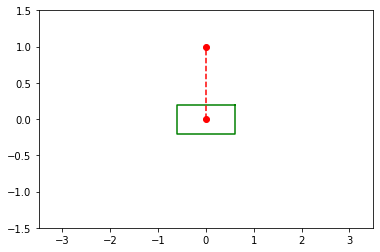

time: 23.4 s (started: 2020-12-30 06:31:15 -05:00)


In [9]:

for i in range(max_iter):
    curr_x = history_q[i]
    x1,y1, x2, y2 = coord_cartpole(curr_x,config)
    pl.clf()
    pl.plot(x1, y1, 'g-',x2, y2, 'r--o')
    pl.xlim(-3.5, 3.5)
    pl.ylim(-1.5,1.5)
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(0.001)

# Visualization states and input

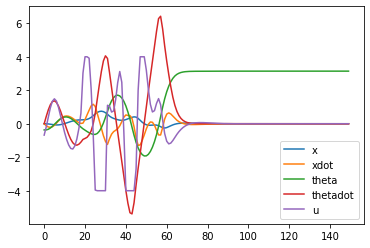

time: 248 ms (started: 2020-12-30 06:37:19 -05:00)


In [10]:
x=[]
xdot=[]
th=[]
thdot=[]
for i in range(max_iter):
    x.append(history_q[i][0])
    xdot.append(history_q[i][1])
    th.append(history_q[i][2])
    thdot.append(history_q[i][3])
 

plt.plot(x)
plt.plot(xdot)
plt.plot(th)
plt.plot(thdot)
plt.plot(history_u)
plt.legend(['x','xdot','theta','thetadot','u'])

In [10]:
NNinputs = []
NNout=[]
max_iter=config["iters"]
history_q = []
history_u = []
for i in range(20000):
    curr_q = np.random.randn(4)
    curr_q = np.reshape(curr_q,[4,1])
    u = np.array(np.ones(Np))
    NNinputs.append(curr_q) 
    
    out=minimize(cost_fn,u,(curr_q,config), method='L-BFGS-B', bounds=bound,
                options={'disp': False})
    u=out.x
    NNout.append(u[0])
    if i%200==0:
        print('iteration :\t',i)



    

iteration :	 0
iteration :	 200
iteration :	 400
iteration :	 600
iteration :	 800
iteration :	 1000
iteration :	 1200
iteration :	 1400
iteration :	 1600
iteration :	 1800
iteration :	 2000
iteration :	 2200
iteration :	 2400
iteration :	 2600
iteration :	 2800
iteration :	 3000
iteration :	 3200
iteration :	 3400
iteration :	 3600
iteration :	 3800
iteration :	 4000
iteration :	 4200
iteration :	 4400
iteration :	 4600
iteration :	 4800
iteration :	 5000
iteration :	 5200
iteration :	 5400
iteration :	 5600
iteration :	 5800
iteration :	 6000
iteration :	 6200
iteration :	 6400
iteration :	 6600
iteration :	 6800
iteration :	 7000
iteration :	 7200
iteration :	 7400
iteration :	 7600
iteration :	 7800
iteration :	 8000
iteration :	 8200
iteration :	 8400
iteration :	 8600
iteration :	 8800
iteration :	 9000
iteration :	 9200
iteration :	 9400
iteration :	 9600
iteration :	 9800
iteration :	 10000
iteration :	 10200
iteration :	 10400
iteration :	 10600
iteration :	 10800
iteration :	

In [11]:
print("Input dimensions for NN: ",np.shape(NNinputs))
print("Output dimensions for NN: ",np.size(NNout))



Input dimensions for NN:  (20000, 4, 1)
Output dimensions for NN:  20000
time: 20.3 ms (started: 2021-01-19 05:35:12 -05:00)


# Storing Data

In [12]:
def store_data(filename,inputs,outputs):
    # Storing to csv File
    count=np.size(outputs)
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        for c in range(count):
            
            # writer.writerow(["Tweets", "Labels"])
            writer.writerow([inputs[c][0][0],inputs[c][1][0], 
                             inputs[c][2][0],inputs[c][3][0],
                            outputs[c]])

    file.close()



time: 955 µs (started: 2021-01-19 05:35:17 -05:00)


In [13]:
import csv
filename='NNdataMPCrandom.csv'
store_data(filename,NNinputs,NNout)

time: 142 ms (started: 2021-01-19 05:35:19 -05:00)


In [14]:
for i in range(100,130,1):
    
    print(NNout[i])

4.0
4.0
-2.770192658293685
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
-1.7264735251090617
4.0
4.0
-2.186882710368739
1.6487068504194982
4.0
4.0
4.0
-4.0
-2.6934965880988293
2.8070759086943706
4.0
4.0
-3.3477459821791666
-3.2149412310304135
-4.0
3.566588450421162
time: 1.79 ms (started: 2021-01-19 05:35:25 -05:00)
